# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)



In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
# import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import keras

Using TensorFlow backend.


In [3]:

##Data Analysis :- looking each dataset deeply to understand varibles and outliers 
#Portfolio
#Profile
#Transcript

In [4]:
#Knowing about structure
portfolio.head()#(Portfolio have 6 variables: 1. Channel 2.Difficulty 3.Duration 4:id 5:offer_type 6.Reward)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
# data information
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
#Knowing about structure
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
#it shows we have 6 profiling variable avaiblale (1.Age 2.Become_member_on 3.Gender 4.id 5.Income)

In [8]:
#Knowing about structure
transcript.head()#(it has Four varible Event person Time Value)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
# describe the dataset
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [10]:
# describe the dataset
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
# describe the dataset
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
#Rows and colums
portfolio.shape

(10, 6)

In [13]:
#Rows and colums
profile.shape

(17000, 5)

In [14]:
#Rows and colums
transcript.shape

(306534, 4)

In [15]:

# check weather there is a null value or not
#During Analysis we will learn more about each variable but for now we keep in simple and short
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [16]:
# check weather there is a null value or not
#During Analysis we will learn more about each variable but for now we keep in simple and short
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [17]:
# check weather there is a null value or not
#During Analysis we will learn more about each variable but for now we keep in simple and short
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [18]:
# datatype of dataframe
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [19]:
# datatype of dataframe
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [20]:
# datatype of dataframe
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [21]:
#Note : In Transacript and Portfolio Dataset no null values are there. But Profile dataset have null values. 
#So we need to clean it and also check whether it contains Outliers.
#lets dig this dataset.


In [22]:
profile['gender'].unique()# As we can see None Gender can tells us more about outliers.

array([None, 'F', 'M', 'O'], dtype=object)

In [23]:
profile['income'].unique()# As we can see Nan values can tells us more about outliers.

array([     nan,  112000.,  100000.,   70000.,   53000.,   51000.,
         57000.,   46000.,   71000.,   52000.,   42000.,   40000.,
         69000.,   88000.,   59000.,   41000.,   96000.,   89000.,
         33000.,   68000.,   63000.,   30000.,   98000.,   37000.,
         80000.,   48000.,   38000.,   56000.,   93000.,   50000.,
         35000.,   47000.,   87000.,   76000.,   64000.,   72000.,
        117000.,   55000.,   77000.,   85000.,   36000.,   91000.,
        107000.,   66000.,   58000.,   74000.,   84000.,   54000.,
         49000.,   73000.,   78000.,   31000.,   60000.,   44000.,
        114000.,   65000.,   79000.,   67000.,   94000.,  108000.,
         61000.,   43000.,   92000.,   62000.,   83000.,   34000.,
        105000.,   82000.,  118000.,  109000.,   99000.,   45000.,
        106000.,   95000.,  103000.,  101000.,  110000.,   86000.,
         39000.,   75000.,   90000.,   81000.,   32000.,  120000.,
        119000.,   97000.,  104000.,  113000.,  115000.,  1110

In [24]:
profile['age'].unique()# As we can see 101, 118 age can tells us more about outliers.

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [25]:
# filter = profile["gender"]=="None"
# profile.where(filter)
# profile

In [26]:

profile.sort_values(by='age', ascending=False)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
3510,118,20180331,None,a94d4b0cca4d47128920f66a5286431d,NaN
12484,118,20160727,None,b04385001db14fdf87829c6163ae9ddd,NaN
3483,118,20170917,None,d4309b7d75174eaa8115f4357b28cd98,NaN
12458,118,20180313,None,c28414b774094421b34abfe44c6d303c,NaN
3491,118,20160421,None,f02fa2294c24490db75354d38a1eabad,NaN
3494,118,20180414,None,da5724d9ac2c45feaa532cdfd4f1ec4a,NaN
3498,118,20140512,None,5e940120796c4804ae4a5e1f30838acd,NaN
3502,118,20150524,None,dd37f142a5354f539b2f246cd5a4a6d3,NaN
12432,118,20150831,None,e1c5485f813a47a984401e3f8e618d40,NaN


In [27]:
# check for age

profile.sort_values(by='age', ascending=False)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
3510,118,20180331,None,a94d4b0cca4d47128920f66a5286431d,NaN
12484,118,20160727,None,b04385001db14fdf87829c6163ae9ddd,NaN
3483,118,20170917,None,d4309b7d75174eaa8115f4357b28cd98,NaN
12458,118,20180313,None,c28414b774094421b34abfe44c6d303c,NaN
3491,118,20160421,None,f02fa2294c24490db75354d38a1eabad,NaN
3494,118,20180414,None,da5724d9ac2c45feaa532cdfd4f1ec4a,NaN
3498,118,20140512,None,5e940120796c4804ae4a5e1f30838acd,NaN
3502,118,20150524,None,dd37f142a5354f539b2f246cd5a4a6d3,NaN
12432,118,20150831,None,e1c5485f813a47a984401e3f8e618d40,NaN


In [28]:
profile[['gender', "age", "income"]][profile['age']>=100] .head(2500)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


In [29]:
profile[['gender', "age", "income"]][profile['age']==101] .head(2500)


,gender,age,income
1556,F,101,43000.0
4100,F,101,99000.0
14846,F,101,56000.0
15800,F,101,59000.0
16864,F,101,82000.0


In [30]:
#it clearly shows age group 118 is outlier as 101 have female gender corresponing to it.
#letsplot graph to see whether its left skwewwed or right skwewed

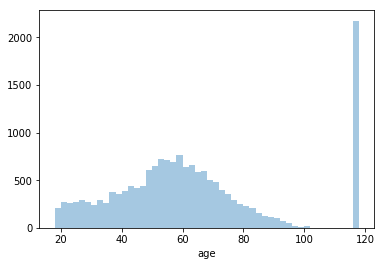

In [31]:
plt.figure()
sns.distplot(profile['age'], bins=50, kde=False);

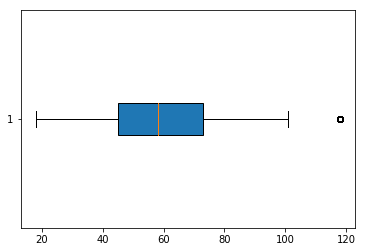

In [32]:
plt.boxplot(profile['age'],vert=0,patch_artist=True)
plt.show()


In [33]:
## Data Processing plus Data cleaning
#here we will do some scaling which will helps us during model building. So that fields need transformation.
#Also we will rename some fields and create some dataframe from poriginal data which will further helps in analyis



In [34]:
#Created datasets copies as we can rename and format the fields required for analysis,
#it always good practice to make copy of data  because it that you always can go back and 
#see you orginal data incase your formating or any tings mislead.
df_portfolio= portfolio.copy()
df_profile = profile.copy()
df_transcript = transcript.copy()

In [35]:
df_portfolio= portfolio.copy()
#DF_portfolio is handled for making numerical variables using key value pair for better handling dat during MODEL built.
# change duration column in hours and rename it to duration_hours
df_portfolio['duration'] = df_portfolio['duration']*24
df_portfolio.rename(columns={'duration':'duration_hours'}, inplace=True)

# Vraibles are converted to numeric fields
scaler = MinMaxScaler() 
numerical = ['difficulty','reward']
df_portfolio[numerical] = scaler.fit_transform(df_portfolio[numerical])
offer_ids = df_portfolio['id'].astype('category').cat.categories.tolist()
new_offer_ids = {'id' : {k: v for k,v in zip(offer_ids,list(range(1,len(offer_ids)+1)))}}
df_portfolio.replace(new_offer_ids, inplace=True)
df_portfolio.rename(columns={'id':'offer_id'}, inplace=True)
offer_types = df_portfolio['offer_type'].astype('category').cat.categories.tolist()
new_offer_types = {'offer_type' : {k: v for k,v in zip(offer_types,list(range(1,len(offer_types)+1)))}}
df_portfolio.replace(new_offer_types, inplace=True)


# split channel into diffrent column, to look multichannel segmentaion 

df_portfolio['Web_channel'] =  df_portfolio['channels'].apply(lambda x: 1 if 'Web' in x else 0)
df_portfolio['Email_channel'] = df_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
df_portfolio['Social_channel'] = df_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
df_portfolio['Mobile_channel'] = df_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
# drop the column channel
df_portfolio.drop('channels', axis=1, inplace=True)
df_portfolio.head()


,difficulty,duration_hours,offer_id,offer_type,reward,Web_channel,Email_channel,Social_channel,Mobile_channel
0,0.50,168,8,1,1.0,0,1,1,1
1,0.50,120,5,1,1.0,0,1,1,1
2,0.00,96,4,3,0.0,0,1,0,1
3,0.25,168,7,1,0.5,0,1,0,1
4,1.00,240,1,2,0.5,0,1,0,0


In [36]:
df_portfolio.shape

(10, 9)

In [37]:
df_profile = profile.copy()

In [38]:

#DF_profile is handled for making numerical variables using key value pair for better handling dat during MODEL built.
customer_ids = df_profile['id'].astype('category').cat.categories.tolist()
new_customer_ids = {'id' : {k: v for k,v in zip(customer_ids,list(range(1,len(customer_ids)+1)))}}
df_profile.replace(new_customer_ids, inplace=True)

df_profile.rename(columns={'id':'customer_id'},inplace=True)

#Age Segments
df_profile['age_group'] = pd.cut(df_profile['age'], bins=[17, 34, 51,70, 103],labels=['Gen_Z', 'Gen_Y ', 'Gen_X', 'Baby_Boom'])

#Income Segmentation
df_profile['income_range'] = pd.cut(df_profile['income'], bins=[29999, 60000, 90000, 120001],labels=['Low', 'Medium', 'high'])


genders = df_profile['gender'].astype('category').cat.categories.tolist()
new_map_gender = {'gender' : {k: v for k,v in zip(genders,list(range(1,len(genders)+1)))}}
df_profile.replace(new_map_gender, inplace=True)
df_profile.head()

,age,became_member_on,gender,customer_id,income,age_group,income_range
0,118,20170212,NaN,6962,NaN,NaN,NaN
1,55,20170715,1.0,399,112000.0,Gen_X,high
2,118,20180712,NaN,3747,NaN,NaN,NaN
3,75,20170509,1.0,7997,100000.0,Baby_Boom,high
4,118,20170804,NaN,10736,NaN,NaN,NaN


In [39]:
df_profile = profile.copy()
#DF_profile is handled for making numerical variables using key value pair for better handling dat during MODEL built.
customer_ids = df_profile['id'].astype('category').cat.categories.tolist()
new_customer_ids = {'id' : {k: v for k,v in zip(customer_ids,list(range(1,len(customer_ids)+1)))}}
df_profile.replace(new_customer_ids, inplace=True)

df_profile.rename(columns={'id':'customer_id'},inplace=True)

#Age Segments
df_profile['age_group'] = pd.cut(df_profile['age'], bins=[17, 34, 51,70, 103],labels=['Gen_Z', 'Gen_Y ', 'Gen_X', 'Baby_Boom'])
#Converting Age group into numeric numbers
age_groups = df_profile['age_group'].astype('category').cat.categories.tolist()
new_age_groups = {'age_group' : {k: v for k,v in zip(age_groups,list(range(1,len(age_groups)+1)))}}
df_profile.replace(new_age_groups, inplace=True)
#Income Segmentation
df_profile['income_range'] = pd.cut(df_profile['income'], bins=[29999, 60000, 90000, 120001],labels=['Low', 'Medium', 'high'])
income_ranges = df_profile['income_range'].astype('category').cat.categories.tolist()
income_ranges = {'income_range' : {k: v for k,v in zip(income_ranges,list(range(1,len(income_ranges)+1)))}}
df_profile.replace(income_ranges, inplace=True)

genders = df_profile['gender'].astype('category').cat.categories.tolist()
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')
df_profile['year'] = df_profile['became_member_on'].apply(lambda x: str(x)[:4])
new_map_gender = {'gender' : {k: v for k,v in zip(genders,list(range(1,len(genders)+1)))}}
df_profile.replace(new_map_gender, inplace=True)
df_profile.drop(columns = ['age','income'], axis=1, inplace=True)
df_profile.head(5)

,became_member_on,gender,customer_id,age_group,income_range,year
0,2017-02-12,NaN,6962,NaN,NaN,2017
1,2017-07-15,1.0,399,3.0,3.0,2017
2,2018-07-12,NaN,3747,NaN,NaN,2018
3,2017-05-09,1.0,7997,4.0,3.0,2017
4,2017-08-04,NaN,10736,NaN,NaN,2017


In [40]:
new_age_groups

{'age_group': {'Gen_Z': 1, 'Gen_Y ': 2, 'Gen_X': 3, 'Baby_Boom': 4}}

In [41]:
income_ranges

{'income_range': {'Low': 1, 'Medium': 2, 'high': 3}}

In [42]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [43]:
df_transcript= transcript.copy()
# df_transcript.rename(columns={'person':'customer_id'},inplace=True)
new_customer_ids = {'person' : {k: v for k,v in zip(customer_ids,list(range(1,len(customer_ids)+1)))}}
df_transcript.replace(new_customer_ids, inplace=True)
df_transcript['days'] = df_transcript['time'].apply(lambda x: int(x / 24) + (x % 24 > 0))
df_transcript['offer_ids'] = df_transcript['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'] if 'offer_id' in x else np.nan)
offer_ids = df_transcript['offer_ids'].astype('category').cat.categories.tolist()
new_offer_id = {'offer_ids' : {k: v for k,v in zip(offer_ids,list(range(1,len(offer_ids)+1)))}}
df_transcript.replace(new_offer_id, inplace=True)
df_transcript['amount'] = df_transcript['value'].apply(lambda x: x['amount']  if 'amount' in x else x['amount'] if 'amount' in x else 0)
df_transcript['reward'] = df_transcript['value'].apply(lambda x: x['reward']  if 'reward' in x else x['reward'] if 'reward' in x else 0)
events = df_transcript['event'].astype('category').cat.categories.tolist()
new_map_events = {'event' : {k: v for k,v in zip(events,list(range(1,len(events)+1)))}}


df_transcript.replace(new_map_events, inplace=True)
df_transcript.drop(['value'], axis=1, inplace=True)
df_transcript.head(5)

,event,person,time,days,offer_ids,amount,reward
0,2,7997,0,0,7.0,0.0,0
1,2,10736,0,0,1.0,0.0,0
2,2,15044,0,0,3.0,0.0,0
3,2,9525,0,0,10.0,0.0,0
4,2,6940,0,0,5.0,0.0,0


In [44]:
new_map_events

{'event': {'offer completed': 1,
  'offer received': 2,
  'offer viewed': 3,
  'transaction': 4}}

In [45]:
new_map_events

{'event': {'offer completed': 1,
  'offer received': 2,
  'offer viewed': 3,
  'transaction': 4}}

In [46]:
new_offer_ids

{'id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [47]:
new_offer_id

{'offer_ids': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
  '2298d6c36e964ae4a3e7e9706d1fb8c2': 2,
  '2906b810c7d4411798c6938adc9daaa5': 3,
  '3f207df678b143eea3cee63160fa8bed': 4,
  '4d5c57ea9a6940dd891ad53e9dbe8da0': 5,
  '5a8bc65990b245e5a138643cd4eb9837': 6,
  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7,
  'ae264e3637204a6fb9bb56bc8210ddfd': 8,
  'f19421c1d4aa40978ebb69ca19b0e20d': 9,
  'fafdcd668e3743c1bb461111dcafc2a4': 10}}

In [48]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [49]:
# In above Processing and cleaning steps we have changed data type for many varibles are per needed in Model builts but Udirng data Analyis we will surely name that variable in string 
#to give better understanding.

In [50]:
df_profile.dtypes

became_member_on    datetime64[ns]
gender                     float64
customer_id                  int64
age_group                  float64
income_range               float64
year                        object
dtype: object

In [51]:
df_transcript.dtypes

event          int64
person         int64
time           int64
days           int64
offer_ids    float64
amount       float64
reward         int64
dtype: object

In [52]:
df_portfolio.dtypes

difficulty        float64
duration_hours      int64
offer_id            int64
offer_type          int64
reward            float64
Web_channel         int64
Email_channel       int64
Social_channel      int64
Mobile_channel      int64
dtype: object

In [53]:
#Merging Data together is most valuable part
merge_df1 = df_transcript.merge(df_profile, left_on='person', right_on='customer_id', how='left')

# merge_df1 =df_portfolio.merge(df_transcript,left_on='customer_id', right_on='person',how='outer')
final_merge= merge_df1.merge(df_portfolio,  left_on='offer_ids', right_on='offer_id',how ='left')

In [54]:
merge_df1.head()

,event,person,time,days,offer_ids,amount,reward,became_member_on,gender,customer_id,age_group,income_range,year
0,2,7997,0,0,7.0,0.0,0,2017-05-09,1.0,7997,4.0,3.0,2017
1,2,10736,0,0,1.0,0.0,0,2017-08-04,NaN,10736,NaN,NaN,2017
2,2,15044,0,0,3.0,0.0,0,2018-04-26,2.0,15044,3.0,2.0,2018
3,2,9525,0,0,10.0,0.0,0,2017-09-25,NaN,9525,NaN,NaN,2017
4,2,6940,0,0,5.0,0.0,0,2017-10-02,NaN,6940,NaN,NaN,2017


In [55]:
final_merge.head()

,event,person,time,days,offer_ids,amount,reward_x,became_member_on,gender,customer_id,...,year,difficulty,duration_hours,offer_id,offer_type,reward_y,Web_channel,Email_channel,Social_channel,Mobile_channel
0,2,7997,0,0,7.0,0.0,0,2017-05-09,1.0,7997,...,2017,0.25,168.0,7.0,1.0,0.5,0.0,1.0,0.0,1.0
1,2,10736,0,0,1.0,0.0,0,2017-08-04,NaN,10736,...,2017,1.00,240.0,1.0,2.0,0.5,0.0,1.0,0.0,0.0
2,2,15044,0,0,3.0,0.0,0,2018-04-26,2.0,15044,...,2018,0.50,168.0,3.0,2.0,0.2,0.0,1.0,0.0,1.0
3,2,9525,0,0,10.0,0.0,0,2017-09-25,NaN,9525,...,2017,0.50,240.0,10.0,2.0,0.2,0.0,1.0,1.0,1.0
4,2,6940,0,0,5.0,0.0,0,2017-10-02,NaN,6940,...,2017,0.50,120.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0


In [56]:
final_merge.drop(['person','offer_id'], axis=1, inplace=True) #drop the repeated column


In [57]:
final_merge.head()

,event,time,days,offer_ids,amount,reward_x,became_member_on,gender,customer_id,age_group,income_range,year,difficulty,duration_hours,offer_type,reward_y,Web_channel,Email_channel,Social_channel,Mobile_channel
0,2,0,0,7.0,0.0,0,2017-05-09,1.0,7997,4.0,3.0,2017,0.25,168.0,1.0,0.5,0.0,1.0,0.0,1.0
1,2,0,0,1.0,0.0,0,2017-08-04,NaN,10736,NaN,NaN,2017,1.00,240.0,2.0,0.5,0.0,1.0,0.0,0.0
2,2,0,0,3.0,0.0,0,2018-04-26,2.0,15044,3.0,2.0,2018,0.50,168.0,2.0,0.2,0.0,1.0,0.0,1.0
3,2,0,0,10.0,0.0,0,2017-09-25,NaN,9525,NaN,NaN,2017,0.50,240.0,2.0,0.2,0.0,1.0,1.0,1.0
4,2,0,0,5.0,0.0,0,2017-10-02,NaN,6940,NaN,NaN,2017,0.50,120.0,1.0,1.0,0.0,1.0,1.0,1.0


In [58]:
final_merge_cp = final_merge.copy()

In [59]:
final_merge_cp.head()

,event,time,days,offer_ids,amount,reward_x,became_member_on,gender,customer_id,age_group,income_range,year,difficulty,duration_hours,offer_type,reward_y,Web_channel,Email_channel,Social_channel,Mobile_channel
0,2,0,0,7.0,0.0,0,2017-05-09,1.0,7997,4.0,3.0,2017,0.25,168.0,1.0,0.5,0.0,1.0,0.0,1.0
1,2,0,0,1.0,0.0,0,2017-08-04,NaN,10736,NaN,NaN,2017,1.00,240.0,2.0,0.5,0.0,1.0,0.0,0.0
2,2,0,0,3.0,0.0,0,2018-04-26,2.0,15044,3.0,2.0,2018,0.50,168.0,2.0,0.2,0.0,1.0,0.0,1.0
3,2,0,0,10.0,0.0,0,2017-09-25,NaN,9525,NaN,NaN,2017,0.50,240.0,2.0,0.2,0.0,1.0,1.0,1.0
4,2,0,0,5.0,0.0,0,2017-10-02,NaN,6940,NaN,NaN,2017,0.50,120.0,1.0,1.0,0.0,1.0,1.0,1.0


In [60]:
final_merge.shape

(306534, 20)

In [61]:

final_merge = final_merge.dropna(how='any',axis=0)
final_merge.shape

(148805, 20)

In [62]:
final_merge_cp = final_merge_cp.dropna(how='any',axis=0)
final_merge_cp.shape

(148805, 20)

In [63]:
# Data Analysis

#Q1: AGE segmentaion Split
#Q2: Income Segmentation Split
#Q3 Most Popular offer
#Q4 Gender SPlit for offertype
#Q5 Different Channel SPlit for offertype



In [64]:
#Q1: AGE segmentaion Response:


In [65]:
#Baby Boomers (Roughly 50 to 70 years old)
#Generation X (Roughly 35 – 50 years old)
#Millennials, or Generation Y (18 – 34 years old)
#Generation Z, or iGeneration (Teens & younger)

final_merge['age_group'] = final_merge['age_group'].map({1: 'Gen_Z', 2: 'Gen_Y', 3:'Gen_X', 4:'Baby_Boom'})


In [66]:
final_merge['age_group'].value_counts()

Gen_X        62727
Gen_Y        38231
Baby_Boom    26714
Gen_Z        21133
Name: age_group, dtype: int64

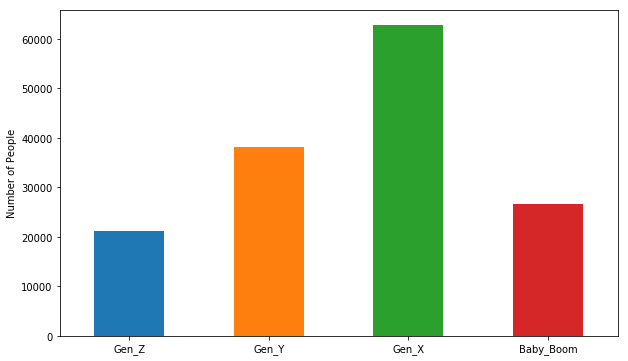

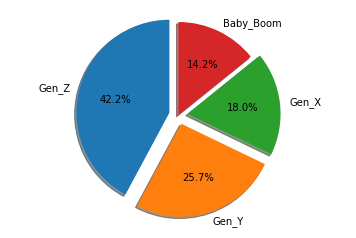

In [67]:
plt.figure(figsize=(10,5))

final_merge.age_group.value_counts().reindex(['Gen_Z', 'Gen_Y', 'Gen_X', 'Baby_Boom']).plot(kind='bar', rot=0, figsize=(10,6));
plt.ylabel('Number of People');
plt.show();



labels=['Gen_Z', 'Gen_Y', 'Gen_X', 'Baby_Boom']
values=final_merge['age_group'].value_counts()

# Gen_X        62727
# Gen_Y        38231
# Baby_Boom    26714
# Gen_Z        21133

#% percentage is seen through Pie CHart 
explode=(0.10,0.10,0.10,0)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

In [68]:
#Insight1: It clearly shows max customer belong to Age- segment Gen_X which is 35-50.

In [69]:
#Q1: Income segmentaion Response:
final_merge['income_range'] = final_merge['income_range'].map({1: 'Low', 2: 'Medium', 3:'high'})

In [70]:
final_merge['income_range'].value_counts()

Low       64095
Medium    61655
high      23055
Name: income_range, dtype: int64

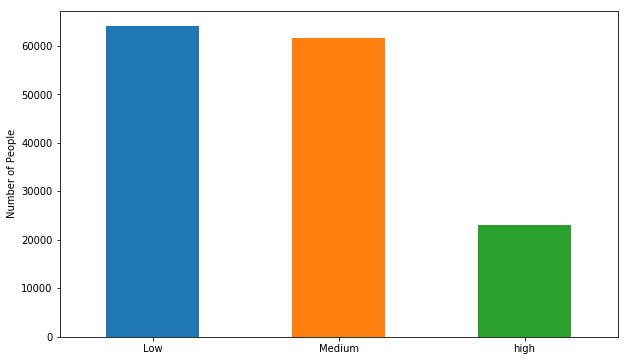

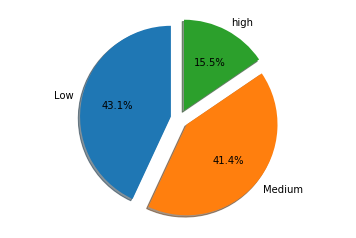

In [71]:
plt.figure(figsize=(10,5))

final_merge.income_range.value_counts().reindex(['Low', 'Medium', 'high']).plot(kind='bar', rot=0, figsize=(10,6));
plt.ylabel('Number of People');

plt.show();

labels=['Low', 'Medium', 'high']
values=final_merge['income_range'].value_counts()

#Low       64095
#Medium    61655
#high      23055

#% percentage is seen through Pie CHart 
explode=(0.10,0.10,0.10)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()





In [72]:
##Insight2: Low income customer base is more dominat.

In [73]:
# Q3 Most Popular Offer

final_merge['offer_type'] = final_merge['offer_type'].map({1: 'BOGO', 2: 'Discount', 3: 'Informational'})


In [74]:
final_merge['offer_type'].value_counts()

BOGO             63834
Discount         62311
Informational    22660
Name: offer_type, dtype: int64

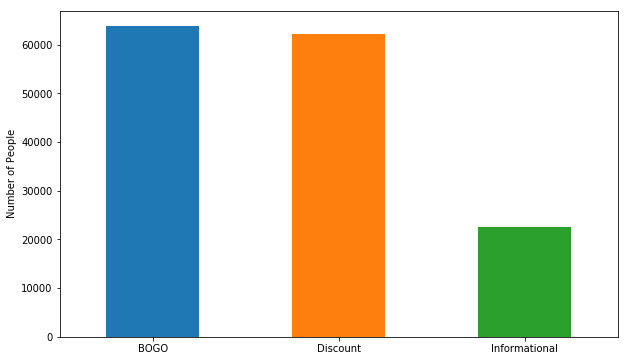

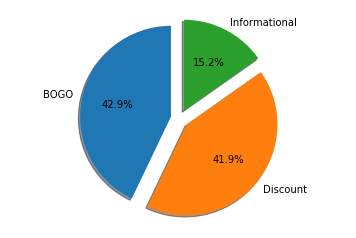

In [75]:
plt.figure(figsize=(10,5))

final_merge.offer_type.value_counts().reindex(['BOGO', 'Discount', 'Informational']).plot(kind='bar', rot=0, figsize=(10,6));
plt.ylabel('Number of People');

plt.show();

labels=['BOGO', 'Discount', 'Informational']
values=final_merge['offer_type'].value_counts()

#Low       64095
#Medium    61655
#high      23055

#% percentage is seen through Pie CHart 
explode=(0.10,0.10,0.10)

fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()



In [76]:
#Insight3 Most Popular offer is BOGO followed by Discount.

In [77]:
#Q4 Gender SPlit for offertype

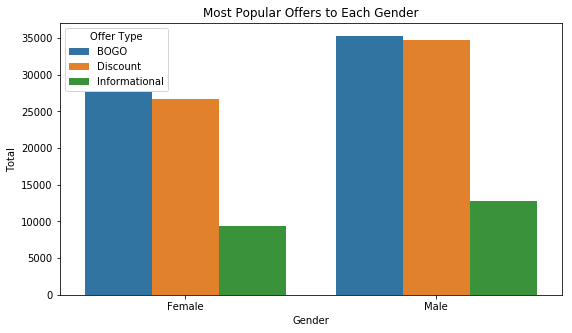

In [78]:
plt.figure(figsize=(9, 5))
g = sns.countplot(x='gender', hue="offer_type", data= final_merge[final_merge["gender"] != 3])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

In [79]:
#Q5 Different Channel SPlit for offertype

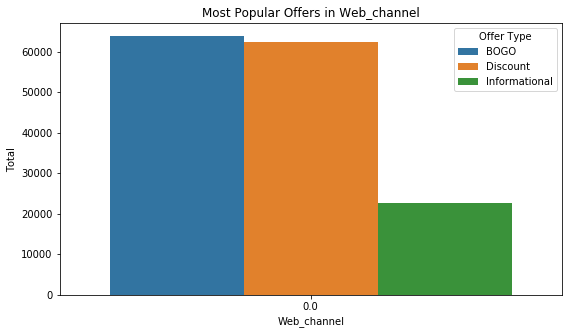

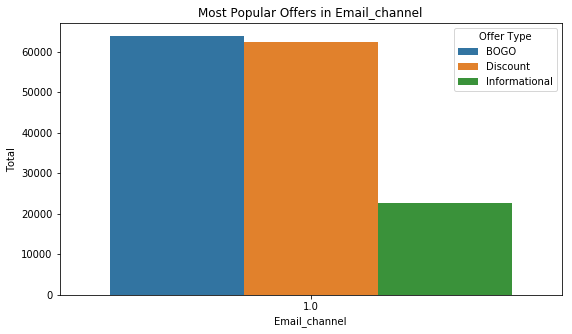

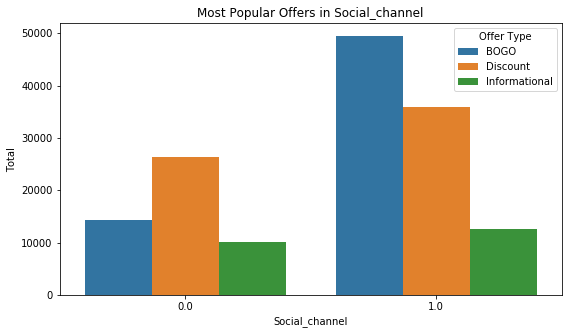

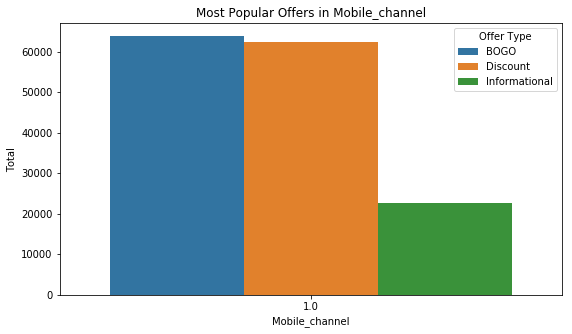

In [80]:
plt.figure(figsize=(9, 5))
g = sns.countplot(x='Web_channel', hue="offer_type", data= final_merge[final_merge["Web_channel"] !=  1])
plt.title('Most Popular Offers in Web_channel')
plt.ylabel('Total')
plt.xlabel('Web_channel')

plt.legend(title='Offer Type')
plt.show();

plt.figure(figsize=(9, 5))
g = sns.countplot(x='Email_channel', hue="offer_type", data= final_merge[final_merge["Email_channel"] != 2])
plt.title('Most Popular Offers in Email_channel')
plt.ylabel('Total')
plt.xlabel('Email_channel')

plt.legend(title='Offer Type')
plt.show();

plt.figure(figsize=(9, 5))
g = sns.countplot(x='Social_channel', hue="offer_type", data= final_merge[final_merge["Social_channel"] != 2])
plt.title('Most Popular Offers in Social_channel')
plt.ylabel('Total')
plt.xlabel('Social_channel')

plt.legend(title='Offer Type')
plt.show();


plt.figure(figsize=(9, 5))
g = sns.countplot(x='Email_channel', hue="offer_type", data= final_merge[final_merge["Mobile_channel"] != 2])
plt.title('Most Popular Offers in Mobile_channel')
plt.ylabel('Total')
plt.xlabel('Mobile_channel')
plt.legend(title='Offer Type')
plt.show();


In [81]:
#Q6 Deepdive on Offer_type vs Event
final_merge['event'] = final_merge['event'].map({1: 'offer completed', 2: 'offer received', 3:'offer viewed',4: 'transaction'})                                            

In [82]:
final_merge.event.value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

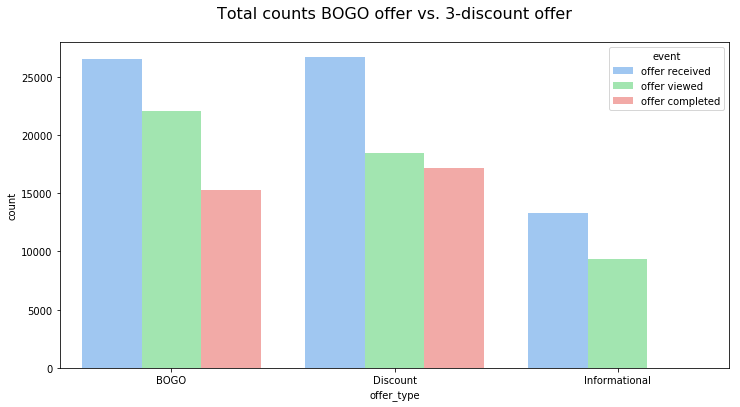

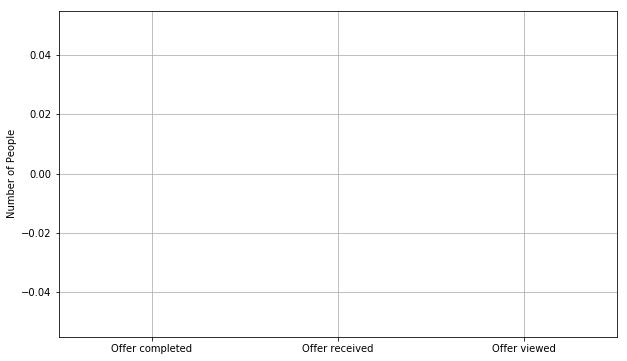

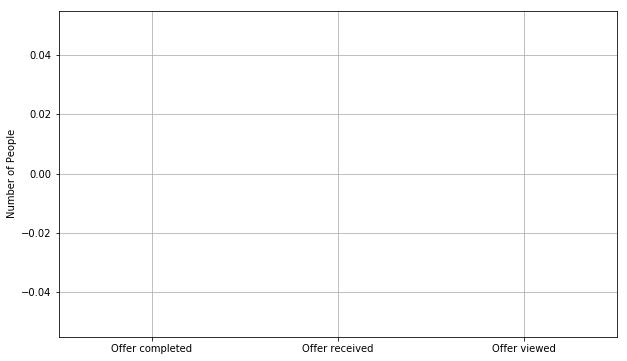

In [83]:


fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(x="offer_type", hue="event", data=final_merge, palette="pastel")
plt.title("Total counts BOGO offer vs. 3-discount offer\n", fontsize=16)
final_merge['event'] = final_merge['event'].map({1: 'Completed', 2: 'Viewed'})





plt.figure(figsize=(10,5))
final_merge.event.value_counts().reindex(['Offer completed','Offer received', 'Offer viewed']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:green');
plt.ylabel('Number of People');
plt.grid();final_merge['event'] = final_merge['event'].map({1: 'offer completed', 2: 'offer received', 3:'offer viewed'})


plt.figure(figsize=(10,5))
final_merge.event.value_counts().reindex(['Offer completed','Offer received', 'Offer viewed']).plot(kind='bar', rot=0, figsize=(10,6), color='tab:green');
plt.ylabel('Number of People');
plt.grid();

In [84]:

#Data Modelling

In [85]:
final_merge_cp.columns

Index(['event', 'time', 'days', 'offer_ids', 'amount', 'reward_x',
       'became_member_on', 'gender', 'customer_id', 'age_group',
       'income_range', 'year', 'difficulty', 'duration_hours', 'offer_type',
       'reward_y', 'Web_channel', 'Email_channel', 'Social_channel',
       'Mobile_channel'],
      dtype='object')

In [86]:
X = final_merge_cp[['offer_ids','amount','reward_x','difficulty','duration_hours','offer_type','gender','age_group','income_range']]
Y = final_merge_cp['event']

scaler = MinMaxScaler()

features = [ 'amount', 'reward_x', 'duration_hours']

X_scaled = X.copy()

X_scaled[features] = scaler.fit_transform(X_scaled[features])

X_scaled.head()
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [87]:
def predict_score(model):
    pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

In [88]:
#decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

dtree.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set are - {round(dtree.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy are - {predict_score(dtree)}%')

Accuracy of Decision Tree classifier on training set are - 66.55%.
Prediction Accuracy are - 87.8506%


In [89]:
#KNN
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set are -  {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy are -  {predict_score(knn)}%')

Accuracy of K-NN classifier on training set are -  64.09%.
Prediction Accuracy are -  85.3122%


In [ ]:
Conclusion:
    
    KNN and decision tree both have predication Accuracy almost similar. SO i would advise to use Decision Tree. 